In [1]:
"""
First insights:

* If an input is trained, it will stay stable, even if it receives less inputs in a second run
* If an input was trained less in a first run, it will strenghten its connections later if its stimuated more often then
* But in this case it will take much more time, since only few spikes are available which takes some time to build up
* If both inputs are trained strongly, further activating patterns have not really any impact anymore
-> An input aquires a specific amount of neurons and stably saturates
-> If it's relatively weak in the beginning it can still become saturates, but then it takes longer

Next steps:
* What happens when the network is bigger?
* What happens when the input it smaller/bigger?
* What happens when a third input comes into play?
* Add noise to allow re-allocation

"""
print('')

In [2]:
import os
import sys

path = '/home/seq/pelenet'
sys.path.append(path)
os.chdir(path)

In [3]:
# Allow reload of objects
%load_ext autoreload
%autoreload

from pelenet.utils import Utils
from pelenet.experiments.assemblies import AssemblyExperiment

# Official modules
import numpy as np
import nxsdk.api.n2a as nx
import matplotlib
import matplotlib.pyplot as plt
from time import time
from copy import deepcopy

In [4]:
# Overwrite default parameters (pelenet/parameters/ and pelenet/experiments/random.py)
parameters = {
    # Experiment
    'seed': 1,  # Random seed
    'trials': 20,  # Number of trials
    'stepsPerTrial': 50,  # Number of simulation steps for every trial
    'isReset': True,  # Activate reset after every trial
    # Network
    'reservoirExSize': 400,  # Number of excitatory neurons
    'reservoirConnPerNeuron': 35, #35 # Number of connections per neuron
    # Noise
    'isNoise': True,
    # Neurons
    'refractoryDelay': 2, # Refactory period
    'voltageTau': 100, #100 # Voltage time constant
    'currentTau': 6, #5 # Current time constant
    'thresholdMant': 1200, #1200  # Spiking threshold for membrane potential
    # Plasticity
    'isLearningRule': True,
    'learningEpoch': 4,
    'learningRule': '2^-2*x1*y0 - 2^-2*y1*x0 + 2^-4*x1*y1*x0*y0 - 2^-3*y0*w*w', #'2^-2*x1*y0 - 2^-2*y1*x0 + 2^-4*x1*y1*y0 - 2^-3*y0*w*w',
    # Input
    'inputIsVary': True,
    'inputVaryProbs': [0.1, 0.9],
    'inputGenSpikeProb': 0.8,  # Probability of spikes for the spike generators
    'inputNumTargetNeurons': 40,  # Number of neurons targeted by the spike generators
    'inputSteps': 30,  # Number of steps the input is active
    # Probes
    'isExSpikeProbe': True,  # Probe excitatory spikes
    'isInSpikeProbe': True,  # Probe inhibitory spikes
    'isWeightProbe': True  # Probe weight matrix at the end of the simulation
}

In [5]:
# Initilizes the experiment and utils
exp = AssemblyExperiment(name='assemblies', parameters=parameters)
utils = Utils.instance()

In [6]:
# Build network
exp.build()

# Get spectral radius
utils.getSpectralRadius(exp.net.initialWeights)

0.922

In [7]:
# Run network
exp.run()

INFO:DRV:  Connecting to 127.0.0.1:38897
INFO:DRV:      Host server up..............Done 0.50s
Compiling in directory : /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1605551495.0692139
Include dir is : /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/ -I/home/seq/pelenet/pelenet/snips/
Compiling -c /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1605551495.0692139/initnetwork_0_0.c
gcc -Wall -I/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/ -I/home/seq/pelenet/pelenet/snips/ -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.

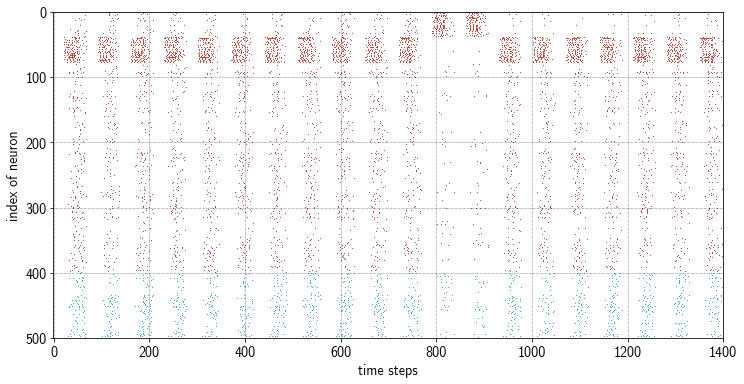

In [8]:
# Plot spike trains of the excitatory (red) and inhibitory (blue) neurons
exp.net.plot.reservoirSpikeTrain(figsize=(12,6))

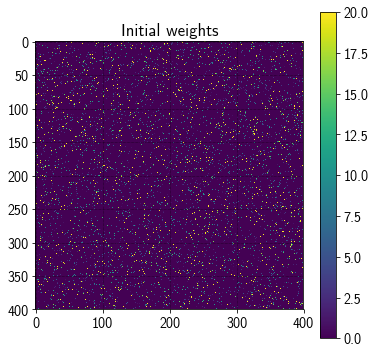

In [9]:
# Weight matrix before learning
exp.net.plot.initialExWeightMatrix()

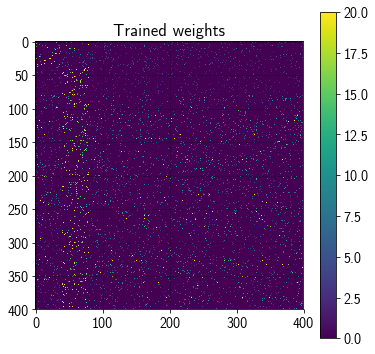

In [10]:
# Weight matrix after learning
exp.net.plot.trainedExWeightMatrix()

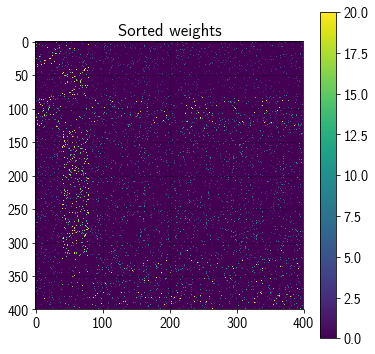

In [11]:
# Sorted weight matrix after learning
expSupportMask = utils.getSupportWeightsMask(exp.net.trainedWeightsExex[-1])
exp.net.plot.weightsSortedBySupport(expSupportMask, exp.net.trainedWeightsExex[-1])

In [12]:
inputs = np.zeros(exp.net.p.trials, dtype=str)
inputs[exp.net.inputTrials[0]] = 'A'
inputs[exp.net.inputTrials[1]] = 'B'
#inputs

In [13]:
supportMasks = []
swm = utils.getSupportWeightsMask(exp.net.initialWeights.exex)
supportMasks.append(swm)

maxSupportNeurons = np.shape(swm)[1]

for i in range(exp.p.trials):
    swm = utils.getSupportWeightsMask(exp.net.trainedWeightsExex[i])
    supportMasks.append(swm)

supportMasks = np.array(supportMasks)

In [14]:
turnover = []
for i in range(exp.p.trials):
    diff = np.subtract(supportMasks[i].astype(int), supportMasks[i+1].astype(int))
    turnover.append(np.sum(np.abs(diff), axis=1))
turnover = np.array(turnover).T

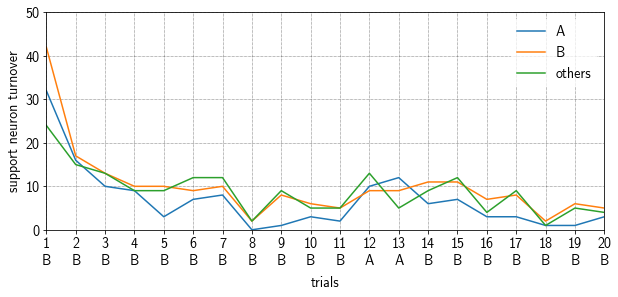

In [15]:
xvals = np.arange(1,21)
plt.figure(figsize=(10,4))
plt.plot(xvals, turnover[0], label='A')
plt.plot(xvals, turnover[1], label='B')
plt.plot(xvals, turnover[2], label='others')
plt.ylim((0,50))
plt.xlim((1,exp.net.p.trials))
plt.ylabel('support neuron turnover')
plt.xlabel('trials', labelpad=25)
plt.xticks(xvals)
plt.legend()
for i in range(20):
    plt.text(i+0.845, -8, inputs[i])
pl = plt.show()

In [16]:
supportShare = np.array([ np.sum(supportMasks[i], axis=1) for i in range(exp.p.trials+1)]).T

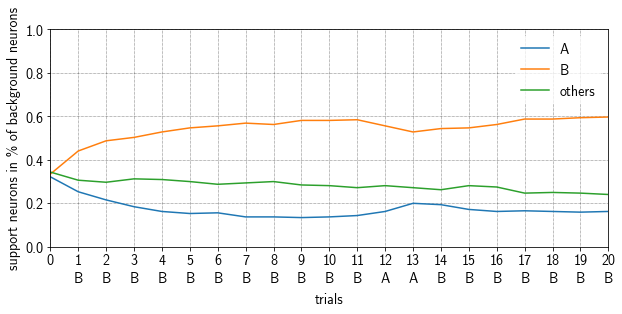

In [17]:
plt.figure(figsize=(10,4))
plt.plot(supportShare[0]/maxSupportNeurons, label='A')
plt.plot(supportShare[1]/maxSupportNeurons, label='B')
plt.plot(supportShare[2]/maxSupportNeurons, label='others')
plt.ylim((0,1))
plt.xlim((0,exp.net.p.trials))
plt.ylabel('support neurons in % of background neurons')
plt.xlabel('trials', labelpad=25)
plt.xticks(np.arange(0, 21))
plt.legend()
for i in range(20):
    plt.text(i+0.845, -0.165, inputs[i])
pl = plt.show()

In [18]:
# New parameters
newParameters = {
    **parameters,
    'trials': 20, #100,
    'inputVaryProbs': [0.9, 0.1]
}

In [19]:
# Initilizes a second experiment
exp2 = AssemblyExperiment(name='assemblies-retrain', parameters=newParameters)

In [20]:
#np.array_equal(exp.initialMasks.exex.toarray(), exp2.initialMasks.exex.toarray())

In [21]:
# Build network
weights = deepcopy(exp.net.initialWeights)
weights.exex = exp.net.trainedWeightsExex[-1]
exp2.buildWithGivenMaskAndWeights(exp.net.initialMasks, weights)

In [22]:
# Run network
exp2.run()

INFO:DRV:  Connecting to 127.0.0.1:36711
INFO:DRV:      Host server up..............Done 0.20s
Compiling in directory : /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1605551543.295886
Include dir is : /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/ -I/home/seq/pelenet/pelenet/snips/
Compiling -c /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1605551543.295886/initnetwork_0_0.c
gcc -Wall -I/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/ -I/home/seq/pelenet/pelenet/snips/ -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/

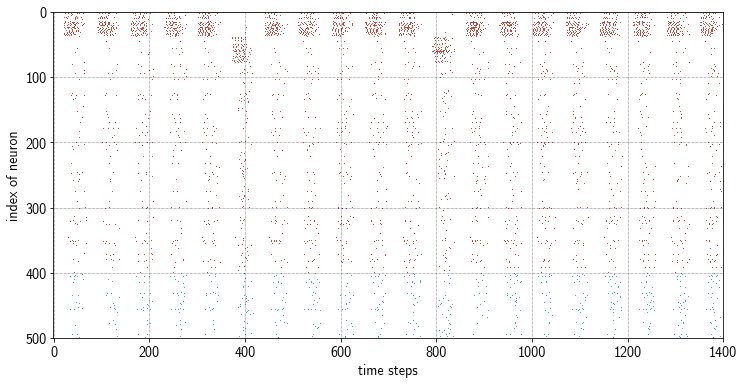

In [23]:
# Plot spike trains of the excitatory (red) and inhibitory (blue) neurons
exp2.net.plot.reservoirSpikeTrain(figsize=(12,6))

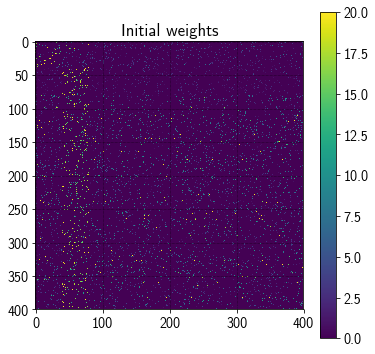

In [24]:
# Weight matrix before learning
exp2.net.plot.initialExWeightMatrix()

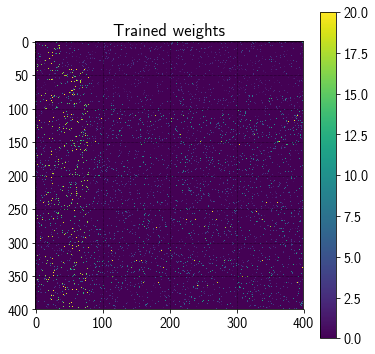

In [25]:
# Weight matrix after learning
exp2.net.plot.trainedExWeightMatrix()

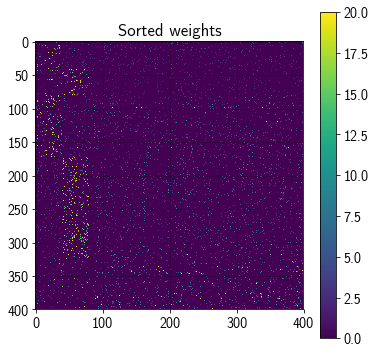

In [26]:
# Sorted weight matrix after learning
exp2SupportMask = utils.getSupportWeightsMask(exp2.net.trainedWeightsExex[-1])
exp2.net.plot.weightsSortedBySupport(exp2SupportMask, exp2.net.trainedWeightsExex[-1])